In [1]:
# Load libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
# Load data
data = pd.read_csv("take_home_data/data/conversion_rates.csv")

In [3]:
# Data characteristics
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           280 non-null    object
 1   male           280 non-null    int64 
 2   age            280 non-null    int64 
 3   has_insurance  280 non-null    int64 
 4   came_from      280 non-null    object
 5   reached_end    280 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 13.2+ KB


In [4]:
# Sample observations
data.head()

,date,male,age,has_insurance,came_from,reached_end
0,2018-09-03,1,32,0,Insurance Site B,1
1,2018-09-07,1,35,0,Insurance Site A,0
2,2018-09-05,1,34,0,Insurance Site C,1
3,2018-09-03,1,32,0,Insurance Site C,1
4,2018-09-05,1,31,0,Google Search,0


In [5]:
# Convert date from string to datetime object, keep month/day
data["date"] = pd.to_datetime(data["date"])
data["date"] = data["date"].dt.strftime("%m-%d")

In [6]:
# Check out sources
data["came_from"].value_counts()

Google Search       83
Insurance Site C    81
Insurance Site B    64
Insurance Site A    52
Name: came_from, dtype: int64

In [7]:
# Generate dummies for sources
data["from_google"] = data["came_from"] == "Google Search"
data["from_google"] = data["from_google"].map({True: 1, False:0})
data["from_a"] = data["came_from"] == "Insurance Site A"
data["from_a"] = data["from_a"].map({True: 1, False:0})
data["from_b"] = data["came_from"] == "Insurance Site B"
data["from_b"] = data["from_b"].map({True: 1, False:0})
data["from_c"] = data["came_from"] == "Insurance Site C"
data["from_c"] = data["from_c"].map({True: 1, False:0})
data = data.drop(columns="came_from")

In [8]:
# Generate treatment variable
data["treatment"] = (data["date"] >= "09-05")
data["treatment"] = data["treatment"].map({True: 1, False:0})

In [9]:
# Make sure everything went okay
data.head()

,date,male,age,has_insurance,reached_end,from_google,from_a,from_b,from_c,treatment
0,09-03,1,32,0,1,0,0,1,0,0
1,09-07,1,35,0,0,0,1,0,0,1
2,09-05,1,34,0,1,0,0,0,1,1
3,09-03,1,32,0,1,0,0,0,1,0
4,09-05,1,31,0,0,1,0,0,0,1


In [10]:
# Describe numeric variables
data[["male", "age", "has_insurance", "reached_end"]].describe().transpose()[["count", "mean", "std"]]

,count,mean,std
male,280.000,0.500,0.501
age,280.000,33.271,2.566
has_insurance,280.000,0.539,0.499
reached_end,280.000,0.464,0.500


In [11]:
# Conversion rate before treatment
data[data.treatment == 0]["reached_end"].mean()

0.3383458646616541

In [12]:
# Conversion rate after treatment
data[data.treatment == 1]["reached_end"].mean()

0.5782312925170068

In [13]:
# Generate daily user counts
daily_rate = data.date.value_counts().sort_index()

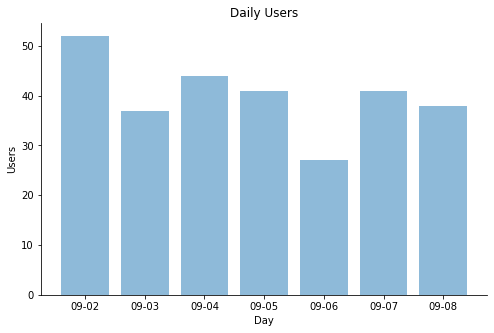

In [14]:
# Graph daily user rates
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(daily_rate.index, daily_rate, alpha=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Daily Users')
ax.set_xlabel('Day')
ax.set_ylabel('Users')

plt.show()

In [15]:
# Generate daily conversion rates
daily_rate = data.groupby("date")["reached_end"].mean()

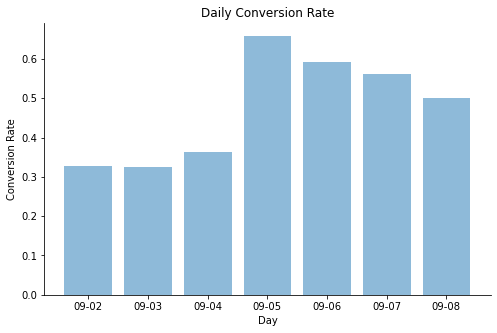

In [16]:
# Graph daily conversion rates
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(daily_rate.index, daily_rate, alpha=0.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Daily Conversion Rate')
ax.set_xlabel('Day')
ax.set_ylabel('Conversion Rate')

plt.show()

In [17]:
# Simple OLS of treatment on conversion
res = smf.ols("reached_end ~ treatment",
             data = data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            reached_end   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     17.02
Date:                Sun, 08 Aug 2021   Prob (F-statistic):           4.89e-05
Time:                        22:55:26   Log-Likelihood:                -194.19
No. Observations:                 280   AIC:                             392.4
Df Residuals:                     278   BIC:                             399.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3383      0.042      8.031      0.0

In [18]:
# Multiple regression including more covariates
# Note: from_c is omitted because it's perfectly colinear with the other sources
# Note: assumed heteroskedasticity for more rigid standard error estimates
# Note: if we actually wanted to make predictions about conversion probabilities, we should use logit,
#       but this regression will suffice for inferential purposes
res = smf.ols("reached_end ~ treatment + male + age + has_insurance + from_google + from_a + from_b",
             data = data).fit(cov_type="HC3")
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            reached_end   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     3.720
Date:                Sun, 08 Aug 2021   Prob (F-statistic):           0.000731
Time:                        22:55:26   Log-Likelihood:                -191.07
No. Observations:                 280   AIC:                             398.1
Df Residuals:                     272   BIC:                             427.2
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7632      0.419      1.821

# Conclusions
- Based on my observations, it appears that the new website feature improved conversion.
- I observed a conversion rate of 33.83% before the feature launch and 57.82% after the feature launch.
- The feature launch did not have a noticeable impact on the number of daily observations.
- A noticeable spike in conversion rate accompanied the feature launch, but this spike dimished daily after the launch.
- In both the simple and multiple regression models, the treatment variable p-value rounded to zero, meaning that shopping after the feature launch has a strong statistical association with reaching the end of flow. The coefficient also had a strong positive value, indicating that the launch led to an increase in conversions.

Based on these findings, we can safely conclude that the feature launch had a positive impact on conversion rate. However, we should be mindful that the impact of the feature launch appeared to diminish each passing day. Therefore, it would be imperative to continue monitoring the conversion rates longer after the launch. Furthermore, we also have a fairly small sample size, especially relative to the amount of covariates we have in the multiple regression model. Although we observed a fairly small p-value for the treatment variable, it would be hard to expand the model with interactions, etc. because standard errors would grow quickly.